# Tuning salt flux correction timescale: Deep convection vs Tamura variability
Three nudging time scales has been set up: TNUDG = 30 low nudging, TNUDGE = 15 mid nudging and TNUDG = 3 hard nudging. To see which one we need I compare the depth of the surface boundary layer and a transsect through the Weddell Sea.
See Aguiar (2017) for deep convection issue in GOCM.

In [1]:
# Generate ROMS and SOSE Xarray datasets
import xarray as xr
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo

src_path = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_path)
# import my functions
import features.roms_ds as roms_ds
import features.sose_ds as sose_ds

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
#load roms_data
rds_path = os.path.join(os.environ.get('rawdir'),'waom10','ocean_avg_0006.nc')
low = roms_ds.make_roms_ds(rds_path)
rds_path = os.path.join(os.environ.get('rawdir'),'waom10_TNUDGE_15','ocean_avg_0006.nc')
mid = roms_ds.make_roms_ds(rds_path)
rds_path = os.path.join(os.environ.get('rawdir'),'waom10_TNUDGE_3','ocean_avg_0006.nc')
high = roms_ds.make_roms_ds(rds_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate
set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate
set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


In [3]:
#load sose_data
sds = sose_ds.make_TS_ds(records=np.arange(0,12))

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


## Surface boundary layer depth comparison

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN axis encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN axis encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN axis encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN axis encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN axis encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN axis encountered
  ret =

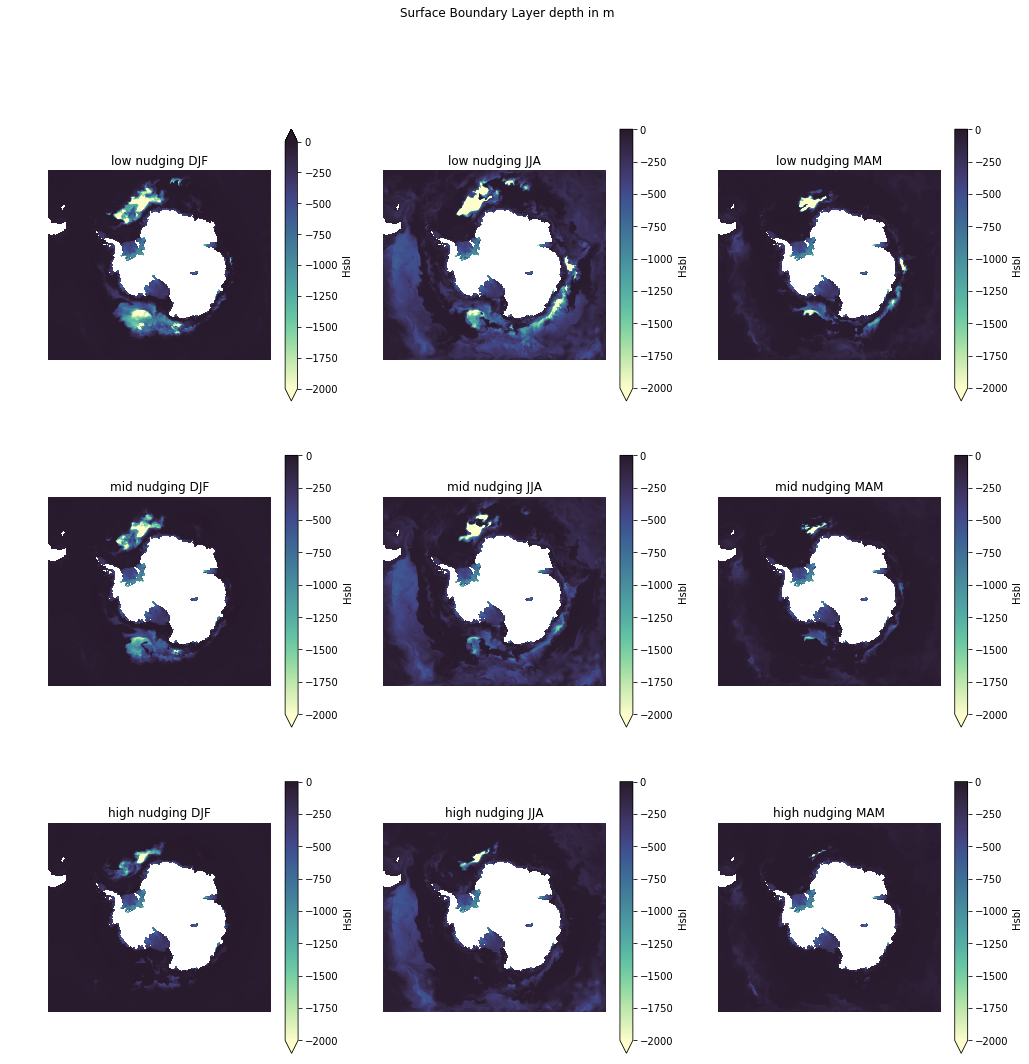

In [4]:
plt.close()
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(17,17))
fig.suptitle('Surface Boundary Layer depth in m')

for ds,ax,case_str in zip([low,mid,high],axes,['low nudging','mid nudging',"high nudging"]):
    season_min = ds.Hsbl.groupby('ocean_time.season').min('ocean_time')
    for season,ax in zip(iter(season_min),ax):
        season.plot(ax=ax,vmax=0,vmin=-2000,cmap=cmo.deep)
        ax.set_title(case_str+' '+str(season.season.values))
        ax.set_aspect('equal')
        ax.axis("off")

plt.show()

* As expected, increasing the nudging strength of surface salt flux reduces strength and frequency of the deep concetion events.
* Even the strongest nudging of TNUDG = 3 days does not fully suppress deep convection. A pathway remains all year in the weddell sea.

## ROMS strongest Nudging vs. SOSE: transsect Weddell Sea

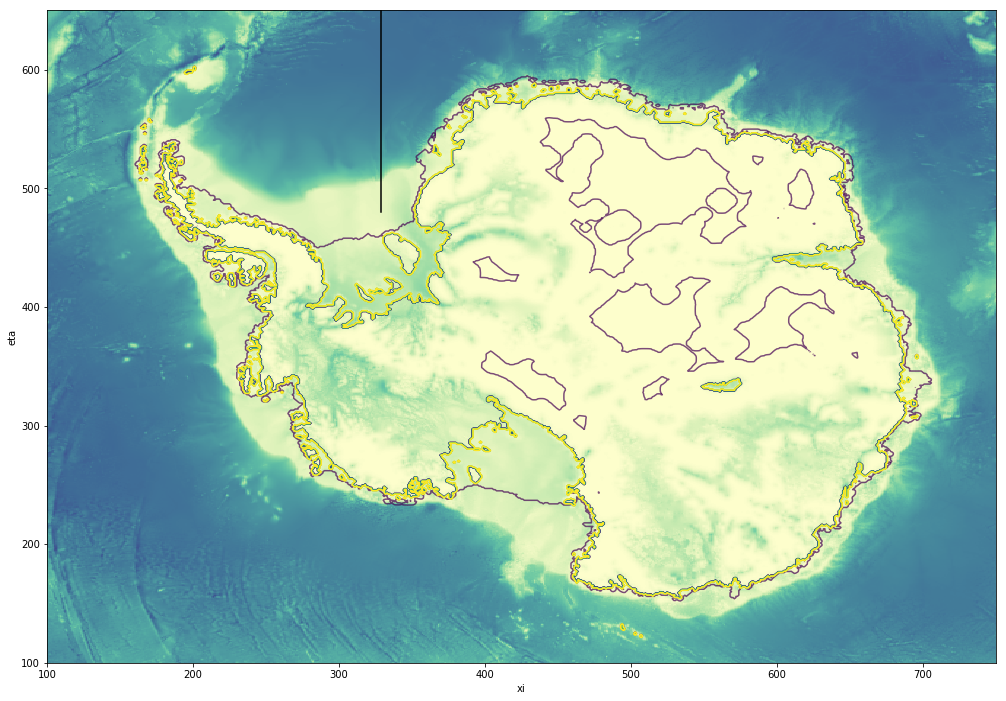

In [6]:
### defining the transsects and plotting them on top of bathy and ice front
plt.close()
fig = plt.figure(figsize=(17,12))
plt.pcolormesh(low.h,cmap=cmo.deep)
plt.contour(low.zice,[-0.01],alpha=0.7)
plt.contour(low.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
#amery=[650,449,850,449,"amery"]
#ross=[450,0,450,240,"ross"]
weddell=[329,480,329,650,"weddel"]
weddell_onshelf=[329,455,329,500,"weddel"]
#bellinghausen=[0,433,225,433,"bellinghausen"]

for line in [weddell]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

plt.xlim((100,750))
plt.ylim((100,650))
plt.show()

In [12]:
### define the plotting function
from ipywidgets import interact
def compare_onshore(rds,sds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))

    x = rds_tr.lat_rho.values.squeeze()
    y = rds_tr.depth.values.squeeze()
    
    lons = rds_tr.lon_rho.to_masked_array().squeeze()
    lons[lons<0]+=360.0
    lats = rds_tr.lat_rho.to_masked_array().squeeze()
    
    lon_da = xr.DataArray(lons,dims='latitude')
    lat_da = xr.DataArray(lats,dims='latitude')
    
    print('calculate mean')
    temp_val = rds_tr.temp.to_masked_array().squeeze()
    salt_val = rds_tr.salt.to_masked_array().squeeze()
    
    print('plot')
    plt.close()
    
    fig,axes = plt.subplots(2,2,figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    
    temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=cmo.thermal)
    plt.colorbar(temp_plt,ax=ax1,label='Temperature in deg C')
    ax1.set_title('ROMS')
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('depth')

    sds.temperature.sel(longitude=lon_da,latitude=lat_da,method='nearest').plot(ax=ax2,vmin=tmin,vmax=tmax,cmap=cmo.thermal)
    ax2.set_title('SOSE')

    salt_plt = ax3.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =cmo.haline)
    plt.colorbar(salt_plt,ax=ax3,label='Salinity in PSU')
    ax3.set_title('ROMS')
    ax3.set_xlabel('latitude')
    ax3.set_ylabel('depth')

    sds.salinity.sel(longitude=lon_da,latitude=lat_da,method='nearest').plot(ax=ax4,vmin=smin,vmax=smax,cmap=cmo.haline)
    ax4.set_title('SOSE')

    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    
    plt.show()        

### Monthly averages widget

In [14]:
def widget(month):
    compare_onshore(high.isel(ocean_time=month),sds.isel(time=month),weddell,tmin=-1.0,tmax=0.0,smin=34.6,smax=34.69,max_depth=5000)
    
interact(widget,month=(0,11))

interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

<function __main__.widget>

### Monthly average July

define slice
calculate mean
plot


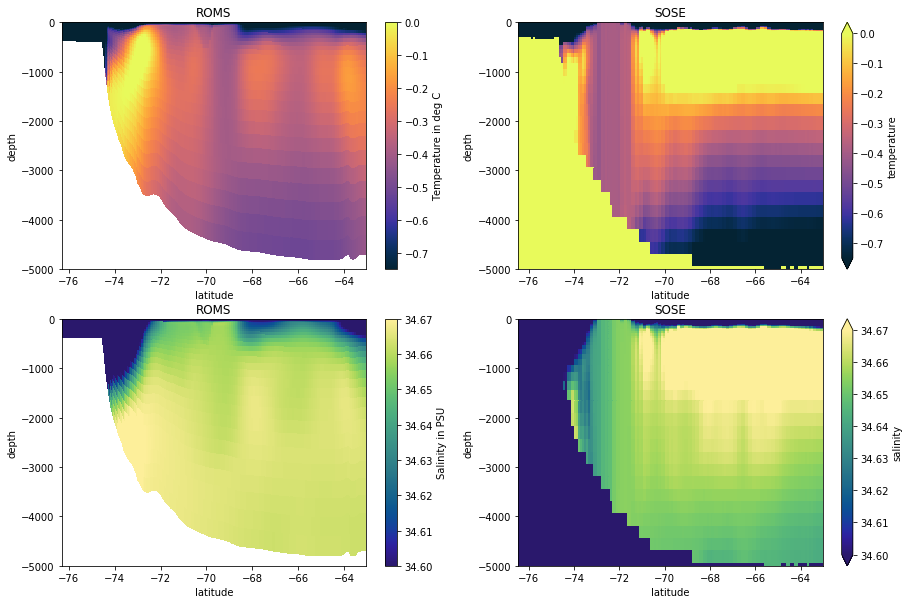

In [21]:
month = 6
compare_onshore(high.isel(ocean_time=month),sds.isel(time=month),weddell,tmin=-0.75,tmax=0.0,smin=34.6,smax=34.67,max_depth=5000)

* SOSE has spurious deep convection as well, therefore surface salt flux correction to SOSE SSS wont solve the issue.

## On shelf convection
To show that even with hard nudging on shelf HSSW production from TAMURA fluxes remains, I plot monthly averages of the on shelf stratification Weddell Sea.

### Monthly averages widget

In [26]:
def widget(month):
    compare_onshore(high.isel(ocean_time=month),sds.isel(time=month),weddell_onshelf,tmin=-2.0,tmax=-1.0,smin=34.0,smax=34.3,max_depth=400)
    
interact(widget,month=(0,11))

interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

<function __main__.widget>

### Monthly average June

define slice
calculate mean
plot


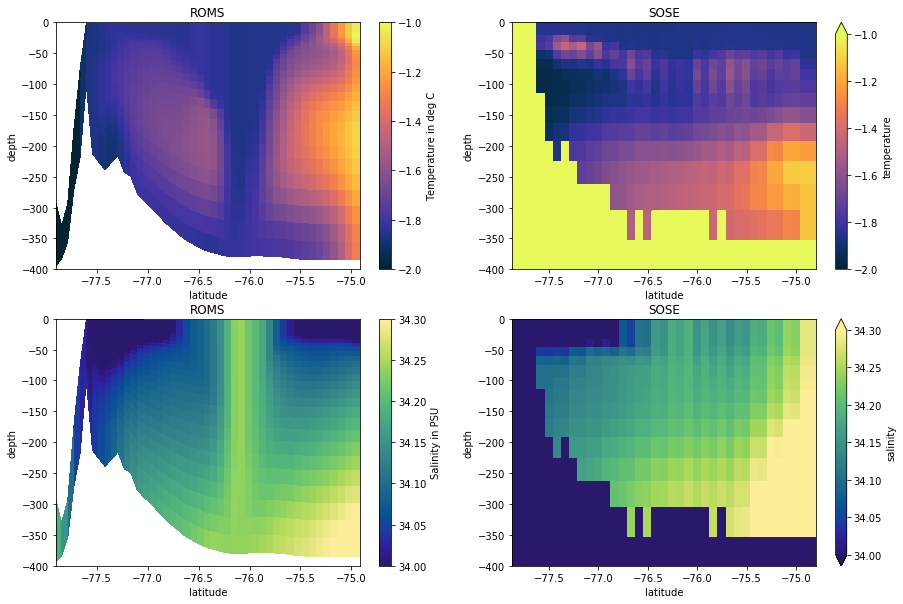

In [28]:
month = 5
compare_onshore(high.isel(ocean_time=month),sds.isel(time=month),weddell_onshelf,tmin=-2.0,tmax=-1.0,smin=34.0,smax=34.3,max_depth=400)